### Import libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data management
import pandas as pd
import numpy as np
import pickle as pkl

from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

# Deep Learning
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, InputLayer

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, mean_squared_error

### Read data

In [224]:
df = pd.read_csv('data/results.csv', parse_dates=['date'])
df_stats = pd.read_csv('data/stats_det2.csv', parse_dates=['date'])
df_teams = pd.read_csv('data/teams.csv', index_col=['team'])

In [225]:
results = df.copy()

In [245]:
def add_games_info(games: pd.DataFrame) -> pd.DataFrame:
    # Change neutral column from boolean to integer
    games['neutral'] = games['neutral'].apply(lambda x: 1 if x else 0)
    # Change countries that no longer exists
    countries_map = {'Czechoslovakia': 'Czech Republic', 'Soviet Union': 'Russia', 'Yugoslavia': 'Serbia', 'German DR': 'Germany'}
    games = games.replace({'home_team': countries_map, 'away_team': countries_map})
    # Create column if the tourname is official or not
    # Tournaments consider official are fiven an arbitrary value depending on the importance, the unofficial games are given 1 point
    official = {
        'FIFA World Cup': 10,
        'Confederations Cup': 8,
        'UEFA Euro': 7,
        'Copa América': 7,
        'FIFA World Cup qualification': 6,
        'FIFA World Cup qualification': 6,
        'African Cup of Nations': 4,
        'African Cup of Nations': 4,
        'CONCACAF Nations League': 0,
        'UEFA Euro qualification': 4,
        'UEFA Nations League': 3,
        'African Cup of Nations qualification': 1
    }
    games['importance'] = games['tournament'].apply(lambda x: official.get(x, 1))

    # Coluimn if the home team won  (1 home won, 0 draw, -1 away won)
    games['winner'] = np.select([games['home_score'] > games['away_score'], 
                                   games['home_score'] == games['away_score'], 
                                   games['home_score'] < games['away_score']], 
                                  [1, 0, -1])
    return games

In [226]:

# Filter out futue games
results = results[~results['home_score'].isnull()]
# Add info
results = add_games_info(results)
# Full list of counties
countries = set(results['home_team'].unique())
countries.update(set(results['away_team'].unique()))

In [228]:
results.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,importance,winner
47319,2024-06-22,Fiji,Tahiti,1.0,0.0,Oceania Nations Cup,Suva,Fiji,0,1,1
47320,2024-06-22,Ecuador,Venezuela,1.0,2.0,Copa América,Santa Clara,United States,1,7,-1
47321,2024-06-22,Mexico,Jamaica,1.0,0.0,Copa América,Houston,United States,1,7,1
47322,2024-06-23,Germany,Switzerland,1.0,1.0,UEFA Euro,Frankfurt,Germany,0,7,0
47323,2024-06-23,Scotland,Hungary,0.0,1.0,UEFA Euro,Stuttgart,Germany,1,7,-1


In [229]:
cols = ['points', 'performance', 'gf', 'ga']
per_cols = [f'{pre}{val}' for pre in ('', 'home_', 'away_', 'neutral_') for val in cols]
performance_cols = ['row_index', 'home', 'away'] + [f'{col}{suf}' for suf in ('_home', '_home_recent', '_away', '_away_recent') for col in per_cols]

team_cols = ['games', 'points', 'gf', 'ga']
team_cols_det = [f'{pre}{val}' for pre in ('', 'home_', 'away_', 'neutral_') for val in team_cols]

In [230]:
def team_performance(team: str, history: pd.DataFrame) -> list[float]:
  # Points, performance, Average goals_f, Average goals_a, Average total goals
  # Total games
  games = history[(history.home_team==team) | (history.away_team==team)]
  if games.empty:
    performances = [0, 0, 0, 0]
  else:
    total_stats = games.groupby(['home_team', 'away_team'], as_index=False).apply(
      lambda x: pd.Series([x.importance.sum()*3,
                          (3*x[((x.home_team==team) & (x.home_score>x.away_score)) | ((x.away_team==team) & (x.away_score>x.home_score))].importance.sum() +x[(x.home_score==x.away_score)].importance.sum()),
                          (x[x.home_team==team].home_score.sum() if not x[x.home_team==team].empty else 0 +\
                            x[x.away_team==team].away_score.sum() if not x[x.away_team==team].empty else 0),
                          (x[x.home_team==team].away_score.sum() if not x[x.home_team==team].empty else 0 +\
                            x[x.away_team==team].home_score.sum() if not x[x.away_team==team].empty else 0)])).iloc[:, 2:].sum()
    total_stats.iloc[1] = total_stats.iloc[1] / total_stats.iloc[0]
    total_stats.iloc[2:] = total_stats.iloc[2:]  / games.shape[0]
    performances = total_stats.tolist()
  # Calculate home performances
  home_stats = history[(history.home_team==team) & (history.neutral==0)].groupby('home_team').apply(
    lambda x: pd.Series([x.importance.sum() * 3, 
                        (x[x.home_score>x.away_score].importance.sum() * 3 + x[x.home_score==x.away_score].importance.sum()) / (3*x.importance.sum()) if not x.empty else 0,
                        x.home_score.mean(), x.away_score.mean()]))
  performances += home_stats.iloc[0].tolist() if not home_stats.empty else [0, 0, 0, 0]
  # Calculate away performances
  away_stats = history[(history.away_team==team) & (history.neutral==0)].groupby('away_team').apply(
    lambda x: pd.Series([x.importance.sum() * 3, 
                        (x[x.home_score>x.away_score].importance.sum() * 3 + x[x.home_score==x.away_score].importance.sum()) / (3*x.importance.sum()) if not x.empty else 0,
                        x.home_score.mean(), x.away_score.mean()]))
  performances += away_stats.iloc[0].tolist() if not away_stats.empty else [0, 0, 0, 0]
  # Calculate neutral performances
  neutral = history[((history.home_team==team) | (history.away_team==team)) & history.neutral==1]
  if neutral.empty:
    performances += [0, 0, 0, 0]
  else:
    neutral_stats = neutral.groupby(['home_team', 'away_team'], as_index=False).apply(
      lambda x: pd.Series([x.importance.sum()*3,
                          (3*x[((x.home_team==team) & (x.home_score>x.away_score)) | ((x.away_team==team) & (x.away_score>x.home_score))].importance.sum() + x[(x.home_score==x.away_score)].importance.sum()),
                          (x[x.home_team==team].home_score.sum() if not x[x.home_team==team].empty else 0 +\
                            x[x.away_team==team].away_score.sum() if not x[x.away_team==team].empty else 0),
                          (x[x.home_team==team].away_score.sum() if not x[x.home_team==team].empty else 0 +\
                            x[x.away_team==team].home_score.sum() if not x[x.away_team==team].empty else 0)])).iloc[:, 2:].sum()
    neutral_stats.iloc[1] = neutral_stats.iloc[1] / neutral_stats.iloc[0]
    neutral_stats.iloc[2:] = neutral_stats.iloc[2:]  / neutral.shape[0]
    performances += neutral_stats.tolist()

  return performances

In [237]:
def get_stats(team: str) -> np.ndarray:
    last_team = df_teams.loc[team]
    if last_team.isnull().sum() > 0:
        new_stats = [0 for _ in per_cols]
        df_teams.loc[team] = [0 for _ in team_cols_det]
        return new_stats
    last_stats = df_stats[(df_stats.home_team==team) | (df_stats.away_team==team)].iloc[-1]
    if last_stats.home_team == team:
        c = len(cols)
        m = 1
        p, po = 'home', 'away'
        l = p
    elif last_stats.away_team == team:
        c = 2*len(cols)
        m = -1
        p, po = 'away', 'home'
        l = p
    if last_stats.neutral == 1:
        c = 3*len(cols)
        l = 'neutral'
        
    new_values = np.array([1, (max(0, m*last_stats.winner) * 3 + (last_stats.winner==0))*last_stats.importance, last_stats[f'{p}_score'], last_stats[f'{po}_score']])
    df_teams.loc[team][team_cols] = np.array([last_team.games, last_team.points, last_team.gf, last_team.ga]) + new_values
    det_cols = [col for col in team_cols_det if l==col[:len(l)]]
    df_teams.loc[team][det_cols] = np.array([last_team[f'{l}_games'], last_team[f'{l}_points'], last_team[f'{l}_gf'], last_team[f'{l}_ga']]) + new_values
    current_team = df_teams.loc[team]
    
    gen_stats = np.round(np.array([last_stats[f'points_{p}'] + last_stats.importance * 3, 
                (current_team.points) / (last_stats[f'points_{p}'] + last_stats.importance * 3),
                current_team.gf / current_team.games, current_team.ga / current_team.games]), 2)
    det_stats = np.round(np.array([last_stats[f'{l}_points_{p}'] + last_stats.importance * 3, 
                (current_team[f'{l}_points']) / (last_stats[f'{l}_points_{p}'] + last_stats.importance * 3),
                current_team[f'{l}_gf'] / current_team[f'{l}_games'], current_team[f'{l}_ga'] / current_team[f'{l}_games']]), 2)
         
    new_stats = last_stats.loc[[col for col in performance_cols if col[-5:]==f'_{p}']].tolist()
    # print(3.1, new_stats)
    # Update the total stats
    new_stats[:len(cols)] = gen_stats
    # Update the specific stats related to the last game
    new_stats[c:c+len(cols)] = det_stats
    # print(3.2, new_stats)
    # Add new stats
    return new_stats

In [232]:
def h2h(row: pd.Series) -> int:
    """Calculate the last 5 official games h2h and assign -3 for each away victory and 3 for home victory"""
    date, home, away = row['date'], row['home_team'], row['away_team']
    games = results[(results.date < date) & (results.importance > 1) &\
        (((results['home_team']==home) & (results['away_team']==away)) |\
            ((results['home_team']==away) & (results['away_team']==home)))].sort_values(by=['date'], ascending=False).head()
    return games.apply(lambda x: 3 if ((x.winner==1 and x.home_team==home) or (x.winner==-1 and x.away_team==home)) else \
        -3 if ((x.winner==-1 and x.away_team==away) or (x.winner==1 and x.home_team==away)) else 0, axis=1).sum()

In [238]:
## Update stats
print(df_stats.shape)
for i, match in results.iloc[47081:].iterrows():
    date, home, away = match[['date', 'home_team', 'away_team']]
    hist = results[results.date < date]
    h_stats = get_stats(home)
    h_recent = team_performance(home, hist[hist.date > date - timedelta(days=3650)])
    a_stats = get_stats(away)
    a_recent = team_performance(away, hist[hist.date > date - timedelta(days=3650)])
    df_stats.loc[df_stats.shape[0]] = match[['date', 'home_team', 'away_team', 'home_score', 'away_score', 
                                             'tournament', 'city', 'country', 'neutral', 'importance', 'winner']].to_list() +\
                                                 h_stats + h_recent + a_stats + a_recent + [h2h(match)]
print(df_stats.shape)

(47075, 76)
(47318, 76)


In [239]:
df_stats.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,importance,...,home_ga_away_recent,away_points_away_recent,away_performance_away_recent,away_gf_away_recent,away_ga_away_recent,neutral_points_away_recent,neutral_performance_away_recent,neutral_gf_away_recent,neutral_ga_away_recent,h2h
47313,2024-06-22,Fiji,Tahiti,1.0,0.0,Oceania Nations Cup,Suva,Fiji,0,1,...,1.285714,42.0,0.523810,1.500000,1.250000,96.0,0.479167,2.411765,0.823529,0.0
47314,2024-06-22,Ecuador,Venezuela,1.0,2.0,Copa América,Santa Clara,United States,1,7,...,1.280000,465.0,0.772043,1.868421,1.052632,333.0,0.429429,1.060606,0.939394,3.0
47315,2024-06-22,Mexico,Jamaica,1.0,0.0,Copa América,Houston,United States,1,7,...,1.000000,285.0,0.550877,1.523810,1.333333,219.0,0.219178,1.300000,1.100000,12.0
47316,2024-06-23,Germany,Switzerland,1.0,1.0,UEFA Euro,Frankfurt,Germany,0,7,...,0.734694,498.0,0.391566,1.181818,1.363636,474.0,0.478903,1.428571,1.285714,6.0
47317,2024-06-23,Scotland,Hungary,0.0,1.0,UEFA Euro,Stuttgart,Germany,1,7,...,0.963636,504.0,0.450397,1.279070,1.255814,105.0,0.333333,1.400000,2.200000,0.0


In [240]:
df_stats.to_csv('./data/stats_det.csv', index=False)
df_teams.to_csv('./data/teams.csv', index=True, index_label='team')

#### Create input

In [249]:
df_input = pd.DataFrame(columns=df_stats.columns)
games = df[(df.date >= '2024-06-24') & (df['tournament']=='UEFA Euro') & (~df.home_team.isnull())].copy().reset_index(drop=True)
games = add_games_info(games)

for i, match in games.iterrows():
    date, home, away = match[['date', 'home_team', 'away_team']]
    print(i, date, home, away)
    hist = results[results.date < date]
    h_stats = get_stats(home)
    h_recent = team_performance(home, hist[hist.date > date - timedelta(days=2555)])
    a_stats = get_stats(away)
    a_recent = team_performance(away, hist[hist.date > date - timedelta(days=2555)])
    df_input.loc[i] = match[['date', 'home_team', 'away_team', 'home_score', 'away_score', 
                             'tournament', 'city', 'country', 'neutral', 'importance', 'winner']].to_list() \
                                 + h_stats + h_recent + a_stats + a_recent + [h2h(match)]

print(df_input.shape) 
df_input = df_input.drop(columns=['home_score', 'away_score', 'winner', 'tournament', 'city', 'country', 'date'])

0 2024-06-24 00:00:00 Albania Spain
1 2024-06-24 00:00:00 Croatia Italy
2 2024-06-25 00:00:00 England Slovenia
3 2024-06-25 00:00:00 Denmark Serbia
4 2024-06-25 00:00:00 Netherlands Austria
5 2024-06-25 00:00:00 France Poland
6 2024-06-26 00:00:00 Slovakia Romania
7 2024-06-26 00:00:00 Ukraine Belgium
8 2024-06-26 00:00:00 Georgia Portugal
9 2024-06-26 00:00:00 Czech Republic Turkey
(10, 76)


In [250]:
df_input.to_csv('./models/america.csv', index=False)

### Input

In [168]:
# Filter out older results
res = df_stats[df_stats['date'].dt.year>=1960]
#('date', 'tournament', 'city', 'country')
#col in ('home_team', 'away_team', 'winner', 'home_score', 'away_score', 'neutral', 'importance', 'h2h')
df_input = res[[col for col in df_stats.columns.tolist() if  col not in ('date', 'tournament', 'city', 'country')]].fillna(0)

print(df_input.shape)
df_input.sample(5)

(42133, 72)


,home_team,away_team,home_score,away_score,neutral,importance,winner,points_home,performance_home,gf_home,...,home_ga_away_recent,away_points_away_recent,away_performance_away_recent,away_gf_away_recent,away_ga_away_recent,neutral_points_away_recent,neutral_performance_away_recent,neutral_gf_away_recent,neutral_ga_away_recent,h2h
24329,Tanzania,Ghana,0.0,1.0,0,6,-1,1212.0,0.33,1.21,...,0.950000,198.0,0.570707,1.511628,0.813953,168.0,0.589286,0.913043,0.913043,-3.0
30270,United States Virgin Islands,Bermuda,0.0,6.0,0,1,-1,123.0,0.05,0.48,...,1.666667,87.0,0.448276,1.777778,1.555556,6.0,0.500000,1.000000,1.500000,0.0
26330,South Korea,China PR,0.0,0.0,0,1,0,3576.0,0.60,1.87,...,0.911765,309.0,0.239482,0.818182,1.515152,117.0,0.581197,2.820513,0.948718,3.0
38023,India,Palestine,2.0,3.0,0,1,-1,1782.0,0.40,1.39,...,1.250000,96.0,0.645833,1.629630,0.814815,96.0,0.614583,1.555556,1.074074,0.0
41958,Myanmar,Cambodia,4.0,1.0,0,1,1,1539.0,0.46,1.68,...,1.464286,96.0,0.843750,3.117647,0.647059,78.0,0.115385,1.062500,2.937500,0.0


In [169]:
index = int(df_input.shape[0] * .9)
train = df_input.iloc[:index, :].fillna(0)
test = df_input.iloc[index:, :].fillna(0)
train.shape, test.shape

((37919, 72), (4214, 72))

In [170]:
X_train, X_test, y, yt = train_test_split(df_input.drop(['home_score', 'away_score', 'winner'], axis=1), df_input.winner, test_size=.1, random_state=42)

Text(0.5, 1.0, 'Testing set')

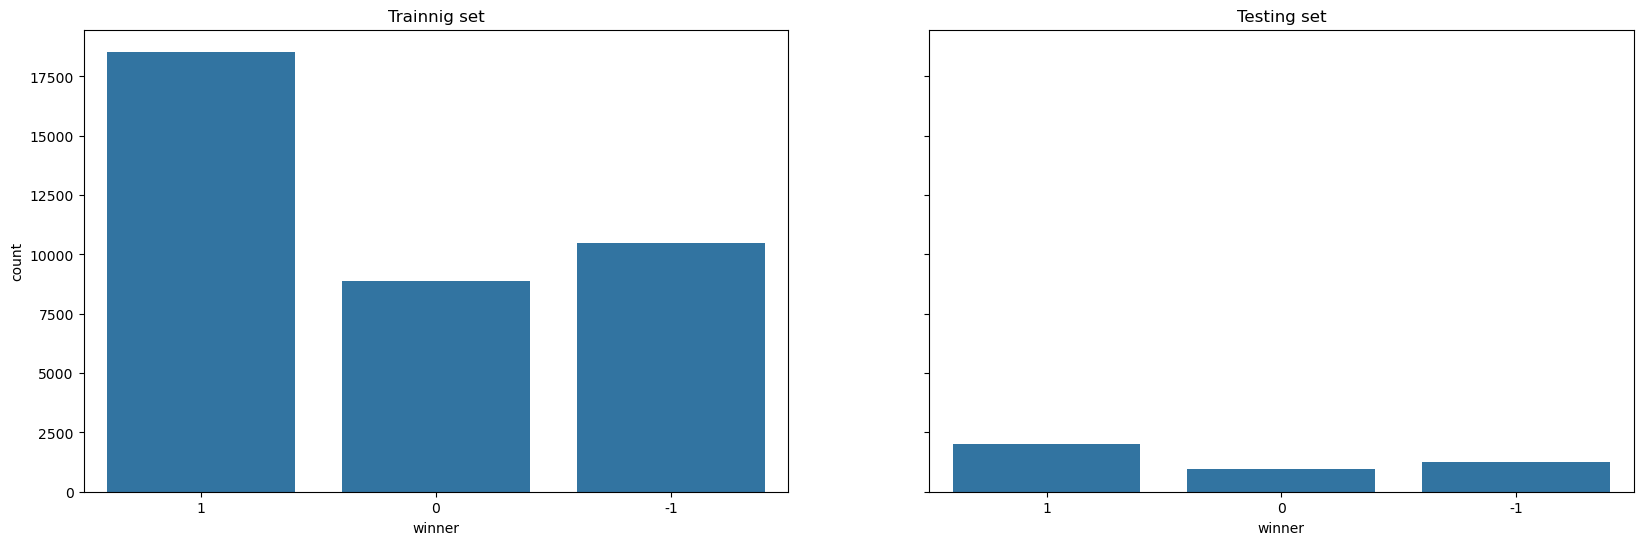

In [164]:
_, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
sns.countplot(train, x='winner', order=[1, 0, -1], ax=axs[0])
axs[0].set_title('Trainnig set')
sns.countplot(test, x='winner', order=[1, 0, -1], ax=axs[1])
axs[1].set_title('Testing set')

In [171]:
X = X_train.drop(['home_team', 'away_team'], axis=1).replace([np.inf, -np.inf], 0.0)
Xt = X_test.drop(['home_team', 'away_team'], axis=1).replace([np.inf, -np.inf], 0.0)

In [124]:
y.value_counts()

winner
 1    17096
-1     9839
 0     8303
Name: count, dtype: int64

In [172]:
# Scale the data
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
scaled_cols = [col for col in X.columns if col in ('importance', 'h2h') or 'points' in col]
X_scaled = X.copy()
X_scaled[scaled_cols] = mm_scaler.fit_transform(X_scaled[scaled_cols])
Xt_scaled = Xt.copy()
Xt_scaled[scaled_cols] = mm_scaler.transform(Xt_scaled[scaled_cols])

In [173]:
pca = PCA(n_components=50)    # X_scaled.shape[1]
X_pca = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_.cumsum())
Xt_pca = pca.transform(Xt_scaled)

[0.26775705 0.44534007 0.5435423  0.59218177 0.63846143 0.67651573
 0.71385816 0.74059785 0.76683289 0.79008366 0.8121005  0.83080913
 0.84795676 0.86323916 0.87594183 0.88708854 0.89769358 0.90760577
 0.91699732 0.92597218 0.93435838 0.94151441 0.94816709 0.95465409
 0.96031506 0.96555547 0.9692418  0.97245834 0.97541129 0.9781959
 0.98073124 0.98310732 0.98473319 0.98625516 0.98752864 0.98878287
 0.98993564 0.99103471 0.9920805  0.99301842 0.9938278  0.99459209
 0.99532092 0.99594808 0.99655454 0.9970679  0.99752119 0.9978486
 0.99814861 0.99842626]


In [174]:
oh_encoder = OneHotEncoder(drop='first')
oh_encoder.fit(df_input[['home_team', 'away_team']])

X_cat = X_train.drop(['home_team', 'away_team'], axis=1).reset_index(drop=True).replace([np.inf, -np.inf], 0.0)
X_cat = pd.concat([X_cat, pd.DataFrame(oh_encoder.transform(X_train[['home_team', 'away_team']]).toarray(), 
                                               columns=oh_encoder.get_feature_names_out())], axis=1)
X_cat[scaled_cols] = mm_scaler.fit_transform(X_cat[scaled_cols])

Xt_cat = X_test.drop(['home_team', 'away_team'], axis=1).reset_index(drop=True).replace([np.inf, -np.inf], 0.0)
Xt_cat = pd.concat([Xt_cat.reset_index(drop=True), pd.DataFrame(oh_encoder.transform(X_test[['home_team', 'away_team']]).toarray(), 
                                                 columns=oh_encoder.get_feature_names_out())], axis=1)
Xt_cat[scaled_cols] = mm_scaler.fit_transform(Xt_cat[scaled_cols])

In [175]:
# Scaler
pca_cat = PCA(n_components=200) # X_pca_cat.shape[1]
X_pca_cat = pca_cat.fit_transform(X_cat)
# X_pca_cat_res, y_pca_res = SMOTE().fit_resample(X_pca_cat, y)
for i, cumsum in enumerate(pca_cat.explained_variance_ratio_.cumsum()):
    if cumsum > .95:
        print(i, cumsum)
        break
print(pca_cat.explained_variance_ratio_.cumsum()[-1])
Xt_pca_cat = pca_cat.transform(Xt_cat)

157 0.9500379911081908
0.9609273675639779


### Models

In [176]:
def plot_confusion_matrix(y_true, y_pred):
    print(type(y_true), type(y_pred))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(7, 4))
    sns.heatmap(cm, annot=True, fmt='.0%', xticklabels=['Away', 'Draw', 'Home'], yticklabels=['Away', 'Draw', 'Home'])
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

#### Logistic Regression

In [177]:
lr_model = LogisticRegression(random_state=0, **{'penalty': 'l2', 'solver': 'newton-cg'})
# lf_selector = RFE(lr_model)
# lf_selector.fit_transform(X_cat, y)
lr_model.fit(X_cat, y)

LogisticRegression(random_state=0, solver='newton-cg')

[[ 654   74  402]
 [ 290   70  672]
 [ 238   64 1750]]
              precision    recall  f1-score   support

          -1       0.55      0.58      0.57      1130
           0       0.34      0.07      0.11      1032
           1       0.62      0.85      0.72      2052

    accuracy                           0.59      4214
   macro avg       0.50      0.50      0.47      4214
weighted avg       0.53      0.59      0.53      4214

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


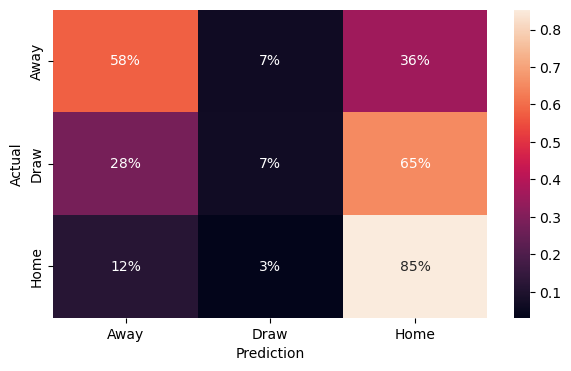

In [179]:
lr_preds = lr_model.predict(Xt_cat)
print(confusion_matrix(yt, lr_preds))
print(classification_report(yt, lr_preds))
plot_confusion_matrix(yt, lr_preds)

#### Neural Networks

In [153]:
# Check GPU usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [181]:
def plot_accuracy(history: tf.keras.callbacks.History) -> None:
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title("Accuracy vs. Epochs")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(loc="lower right")
    plt.show()

In [182]:
# Set the input shape for the NN
tf.random.set_seed(1234)
input_shape = X_cat.shape[1]
backend.clear_session()

##### FNN simple

In [183]:
# backend.clear_session() 
model1 = Sequential()
model1.add(Dense(32, activation="silu", input_shape=(input_shape, )))   # , kernel_regularizer=tf.keras.regularizers.l2(.001)
model1.add(Dropout(.2))
model1.add(Dense(64, activation="silu")) 
model1.add(Dropout(.3))
model1.add(Dense(3, activation="softmax"))
# Create a callack to get the optimal learning rate
# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
# For classification tasks, we can minimize categorical_crossentropy loss
model1.compile(loss="categorical_crossentropy", metrics=["accuracy"], 
               optimizer=tf.keras.optimizers.Nadam(learning_rate=.001))
model1.summary()
history1 = model1.fit(X_cat, pd.get_dummies(y), validation_split=.1, epochs=15, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                22368     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 24,675
Trainable params: 24,675
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1067/1067 - 21s - loss: 0.9341 - accuracy

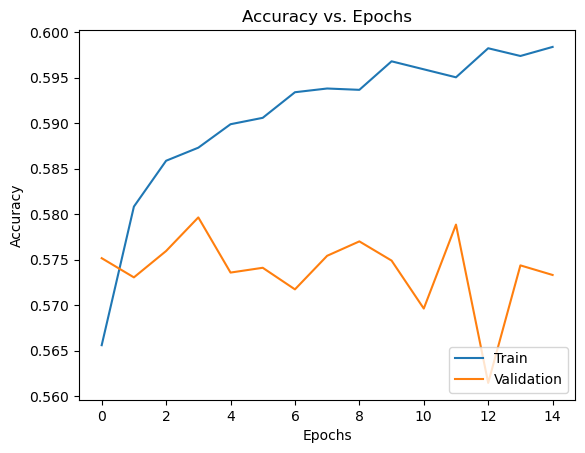

132/132 [==============================] - 0s 2ms/step
[[ 683   26  421]
 [ 310   30  692]
 [ 267   25 1760]]
              precision    recall  f1-score   support

          -1       0.54      0.60      0.57      1130
           0       0.37      0.03      0.05      1032
           1       0.61      0.86      0.71      2052

    accuracy                           0.59      4214
   macro avg       0.51      0.50      0.45      4214
weighted avg       0.53      0.59      0.51      4214

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


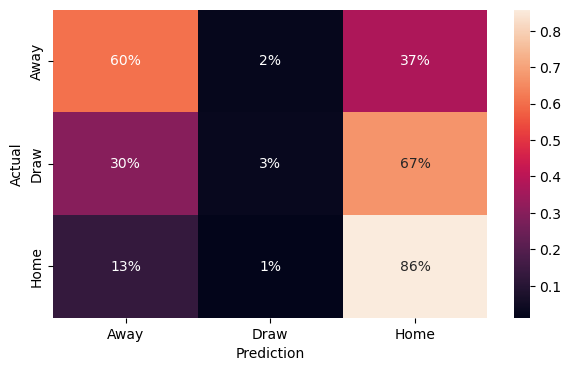

In [184]:
plot_accuracy(history1)
[test.importance==7]
model1_preds = model1.predict(Xt_cat)
print(confusion_matrix(yt, np.argmax(model1_preds, axis=1)-1))
print(classification_report(yt, np.argmax(model1_preds, axis=1)-1))
plot_confusion_matrix(yt, np.argmax(model1_preds, axis=1)-1)

In [ ]:
lrs = 1e-4 * 10**(np.arange(100) / 20)
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history1.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning rate vs. Loss')

##### LSTM

In [185]:
lstm = Sequential()
lstm.add(LSTM(128, input_shape=(1, input_shape), dropout=.3))
# lstm.add(LSTM(32, return_sequences=True, activation='tanh'))
# lstm.add(LSTM(32, activation='sigmoid'))
lstm.add(Dense(3, activation='softmax'))
lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])
lstm.summary()
history3 = lstm.fit(X_cat.to_numpy().reshape(-1, 1, input_shape), pd.get_dummies(y), epochs=15, verbose=2, validation_split=.1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               423424    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 423,811
Trainable params: 423,811
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1067/1067 - 93s - loss: 0.9468 - accuracy: 0.5556 - val_loss: 0.9263 - val_accuracy: 0.5720 - 93s/epoch - 88ms/step
Epoch 2/15
1067/1067 - 34s - loss: 0.9266 - accuracy: 0.5671 - val_loss: 0.9201 - val_accuracy: 0.5759 - 34s/epoch - 31ms/step
Epoch 3/15
1067/1067 - 24s - loss: 0.9200 - accuracy: 0.5701 - val_loss: 0.9185 - val_accuracy: 0.5749 - 24s/epoch - 22ms/step
Epoch 4/15
1067/1067 - 22s - loss: 0.9157 - accuracy: 0.5713 - 

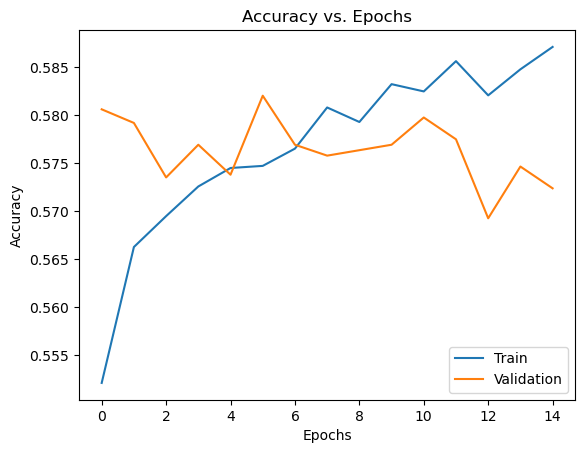

123/123 [==============================] - 1s 3ms/step
[[ 522   86  439]
 [ 228   85  659]
 [ 202   76 1619]]
              precision    recall  f1-score   support

          -1       0.55      0.50      0.52      1047
           0       0.34      0.09      0.14       972
           1       0.60      0.85      0.70      1897

    accuracy                           0.57      3916
   macro avg       0.50      0.48      0.45      3916
weighted avg       0.52      0.57      0.51      3916

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


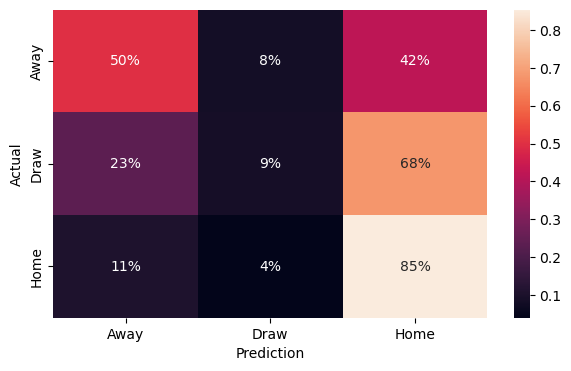

In [163]:
plot_accuracy(history3)
lstm_preds = lstm.predict(Xt_cat.to_numpy().reshape(-1, 1, input_shape))
print(confusion_matrix(yt, np.argmax(lstm_preds, axis=1)-1))
print(classification_report(yt, np.argmax(lstm_preds, axis=1)-1))
plot_confusion_matrix(yt, np.argmax(lstm_preds, axis=1)-1)